In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:
df=pd.read_csv('hospital_deaths_train.csv')


In [3]:
df.head()

,recordid,In-hospital_death,Age,Gender,Height,Weight,CCU,CSRU,SICU,DiasABP_first,...,SysABP_last,TroponinI_last,TroponinT_last,WBC_last,Weight_last,pH_last,MechVentStartTime,MechVentDuration,MechVentLast8Hour,UrineOutputSum
0,135031,0,69.0,1.0,172.7,63.7,0,0,0,59.0,...,119.0,4.6,NaN,17.2,63.7,7.41,105.0,2580.0,1.0,12.0
1,132988,0,72.0,1.0,NaN,NaN,0,0,0,NaN,...,NaN,NaN,0.23,21.9,NaN,NaN,NaN,NaN,NaN,NaN
2,136292,0,29.0,0.0,NaN,90.0,0,0,0,37.0,...,124.0,NaN,NaN,11.1,106.3,7.40,103.0,2700.0,1.0,14.0
3,133122,0,73.0,1.0,175.3,89.1,0,1,0,58.0,...,148.0,NaN,NaN,18.3,94.2,7.45,144.0,2115.0,0.0,12.0
4,142184,0,74.0,0.0,NaN,78.0,0,0,1,47.0,...,187.0,NaN,NaN,17.7,NaN,7.26,75.0,2280.0,0.0,18.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3250 entries, 0 to 3249
Columns: 116 entries, recordid to UrineOutputSum
dtypes: float64(111), int64(5)
memory usage: 2.9 MB


In [5]:
df.shape

(3250, 116)

In [6]:
x = df.drop('In-hospital_death', axis=1)
y = df['In-hospital_death']

In [7]:
feature = ['Age', 'Gender', 'Height', 'CCU', 'CSRU', 'SICU', 'MAP_first',
       'GCS_last', 'MAP_last', 'NIDiasABP_last', 'NIMAP_last',
       'DiasABP_lowest', 'MAP_lowest', 'NISysABP_lowest', 'Temp_lowest',
       'Glucose_highest', 'HR_highest', 'MAP_highest', 'MAP_median',
       'FiO2_first', 'HCO3_first', 'HCT_first', 'K_first', 'Lactate_first',
       'Mg_first', 'Na_first', 'PaCO2_first', 'PaO2_first', 'SysABP_first',
       'WBC_first', 'pH_first', 'BUN_last', 'Creatinine_last', 'FiO2_last',
       'HCO3_last', 'HCT_last', 'K_last', 'Lactate_last', 'Mg_last', 'Na_last',
       'PaCO2_last', 'PaO2_last', 'Platelets_last', 'SysABP_last', 'WBC_last',
       'Weight_last', 'pH_last', 'MechVentStartTime', 'MechVentDuration',
       'MechVentLast8Hour', 'UrineOutputSum']

In [8]:
x = x[feature]

In [9]:
X_train,X_test,Y_train,Y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [10]:
print("Shape of X_train:" ,X_train.shape)
print("Shape of y_train:" ,Y_train.shape)
print("Shape of X_test:"  ,X_test.shape)
print("Shape of y_test:"  ,Y_test.shape)

Shape of X_train: (2600, 51)
Shape of y_train: (2600,)
Shape of X_test: (650, 51)
Shape of y_test: (650,)


In [11]:
from xgboost import XGBClassifier, plot_tree, plot_importance

In [12]:
xgb = XGBClassifier(random_state=42)

In [13]:
xgb.fit(X_train, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [14]:
pred = xgb.predict(X_test)

In [15]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
cf = confusion_matrix(Y_test, pred)

In [16]:
cf

array([[555,  19],
       [ 56,  20]], dtype=int64)

In [17]:
print(classification_report(Y_test, pred))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       574
           1       0.51      0.26      0.35        76

    accuracy                           0.88       650
   macro avg       0.71      0.62      0.64       650
weighted avg       0.86      0.88      0.87       650



In [18]:
Y_test.value_counts()

0    574
1     76
Name: In-hospital_death, dtype: int64

In [19]:
from imblearn.over_sampling import SMOTE

In [20]:
smote = SMOTE(sampling_strategy='minority')

In [21]:
def impute_mode(feature, df):
    mode = df[feature].mode()[0]
    df[feature] = df[feature].fillna(mode)

In [22]:
def random_value_imputation(feature, df):
    random_sample = df[feature].dropna().sample(df[feature].isna().sum(), replace=True)
    random_sample.index = df[df[feature].isnull()].index
    df.loc[df[feature].isnull(), feature] = random_sample

In [23]:
cat_cols = [col for col in X_train.columns if X_train[col].dtype == 'object']
num_cols = [col for col in X_train.columns if X_train[col].dtype != 'object']
print('cat_cols', cat_cols)
print('num_cols', num_cols)

cat_cols []
num_cols ['Age', 'Gender', 'Height', 'CCU', 'CSRU', 'SICU', 'MAP_first', 'GCS_last', 'MAP_last', 'NIDiasABP_last', 'NIMAP_last', 'DiasABP_lowest', 'MAP_lowest', 'NISysABP_lowest', 'Temp_lowest', 'Glucose_highest', 'HR_highest', 'MAP_highest', 'MAP_median', 'FiO2_first', 'HCO3_first', 'HCT_first', 'K_first', 'Lactate_first', 'Mg_first', 'Na_first', 'PaCO2_first', 'PaO2_first', 'SysABP_first', 'WBC_first', 'pH_first', 'BUN_last', 'Creatinine_last', 'FiO2_last', 'HCO3_last', 'HCT_last', 'K_last', 'Lactate_last', 'Mg_last', 'Na_last', 'PaCO2_last', 'PaO2_last', 'Platelets_last', 'SysABP_last', 'WBC_last', 'Weight_last', 'pH_last', 'MechVentStartTime', 'MechVentDuration', 'MechVentLast8Hour', 'UrineOutputSum']


In [24]:
for col in num_cols:
    random_value_imputation(col, X_train)
X_train[num_cols].isnull().sum()

Age                  0
Gender               0
Height               0
CCU                  0
CSRU                 0
SICU                 0
MAP_first            0
GCS_last             0
MAP_last             0
NIDiasABP_last       0
NIMAP_last           0
DiasABP_lowest       0
MAP_lowest           0
NISysABP_lowest      0
Temp_lowest          0
Glucose_highest      0
HR_highest           0
MAP_highest          0
MAP_median           0
FiO2_first           0
HCO3_first           0
HCT_first            0
K_first              0
Lactate_first        0
Mg_first             0
Na_first             0
PaCO2_first          0
PaO2_first           0
SysABP_first         0
WBC_first            0
pH_first             0
BUN_last             0
Creatinine_last      0
FiO2_last            0
HCO3_last            0
HCT_last             0
K_last               0
Lactate_last         0
Mg_last              0
Na_last              0
PaCO2_last           0
PaO2_last            0
Platelets_last       0
SysABP_last

In [25]:
for col in num_cols:
    random_value_imputation(col, X_test)
X_test[num_cols].isnull().sum()

Age                  0
Gender               0
Height               0
CCU                  0
CSRU                 0
SICU                 0
MAP_first            0
GCS_last             0
MAP_last             0
NIDiasABP_last       0
NIMAP_last           0
DiasABP_lowest       0
MAP_lowest           0
NISysABP_lowest      0
Temp_lowest          0
Glucose_highest      0
HR_highest           0
MAP_highest          0
MAP_median           0
FiO2_first           0
HCO3_first           0
HCT_first            0
K_first              0
Lactate_first        0
Mg_first             0
Na_first             0
PaCO2_first          0
PaO2_first           0
SysABP_first         0
WBC_first            0
pH_first             0
BUN_last             0
Creatinine_last      0
FiO2_last            0
HCO3_last            0
HCT_last             0
K_last               0
Lactate_last         0
Mg_last              0
Na_last              0
PaCO2_last           0
PaO2_last            0
Platelets_last       0
SysABP_last

In [26]:
X_train_s, Y_train_s = smote.fit_resample(X_train, Y_train)

In [27]:
std_scale = MinMaxScaler()
X_train_s = std_scale.fit_transform(X_train_s)
X_test = std_scale.transform(X_test)

In [28]:
from sklearn.ensemble import AdaBoostClassifier

xgb = AdaBoostClassifier(n_estimators=130,learning_rate = 1, random_state=42)

In [29]:
xgb.fit(X_train_s, Y_train_s)

AdaBoostClassifier(learning_rate=1, n_estimators=130, random_state=42)

In [30]:
pred_b = xgb.predict(X_test)

In [31]:
con = confusion_matrix(Y_test, pred_b)

con

array([[513,  61],
       [ 48,  28]], dtype=int64)

Text(70.72222222222221, 0.5, 'Actual')

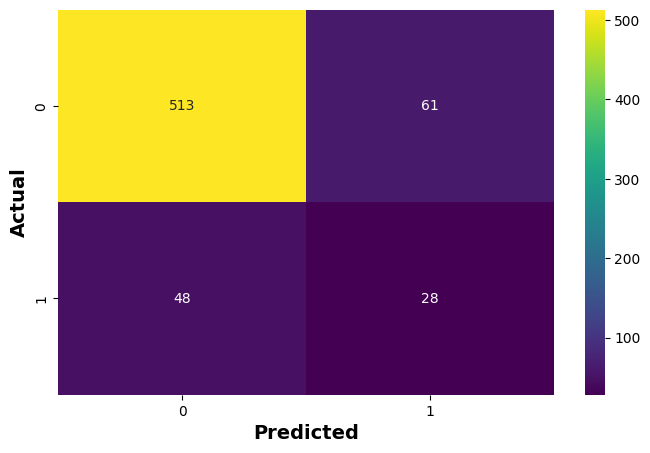

In [32]:
plt.figure(figsize=(8,5))
sns.heatmap(con, annot=True, cmap='viridis', fmt='.0f');
plt.xlabel('Predicted', fontsize=14, weight='bold')
plt.ylabel('Actual', fontsize=14, weight='bold')

In [33]:
tn, fp, fn, tp = confusion_matrix(Y_test, pred_b).ravel()

print(tn)
print(fp)
print(fn)
print(tp)

513
61
48
28


In [34]:
print(classification_report(Y_test, pred_b))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90       574
           1       0.31      0.37      0.34        76

    accuracy                           0.83       650
   macro avg       0.61      0.63      0.62       650
weighted avg       0.84      0.83      0.84       650



In [35]:
print(classification_report(Y_test, pred))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       574
           1       0.51      0.26      0.35        76

    accuracy                           0.88       650
   macro avg       0.71      0.62      0.64       650
weighted avg       0.86      0.88      0.87       650



In [36]:
from sklearn.metrics import RocCurveDisplay
from sklearn import metrics

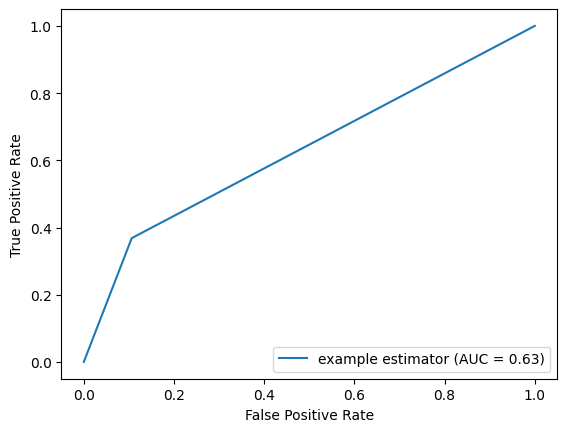

In [37]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test, pred_b)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='example estimator')
display.plot()
plt.show()

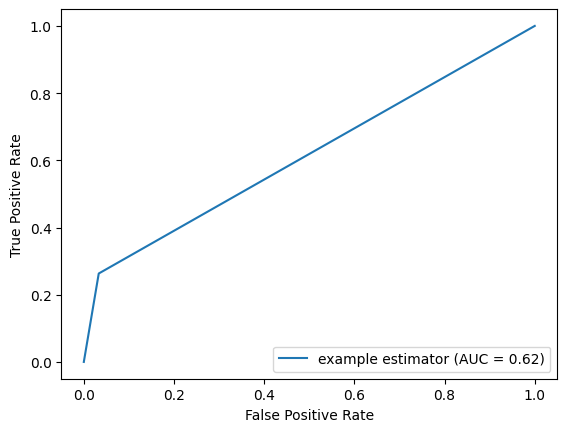

In [38]:
fpr, tpr, thresholds = metrics.roc_curve(Y_test, pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='example estimator')
display.plot()
plt.show()

In [39]:
imp = xgb.feature_importances_

imp

array([0.01538462, 0.08461538, 0.        , 0.00769231, 0.00769231,
       0.00769231, 0.00769231, 0.06153846, 0.00769231, 0.02307692,
       0.01538462, 0.        , 0.01538462, 0.01538462, 0.03076923,
       0.01538462, 0.01538462, 0.00769231, 0.00769231, 0.03846154,
       0.02307692, 0.02307692, 0.00769231, 0.00769231, 0.03846154,
       0.01538462, 0.01538462, 0.00769231, 0.01538462, 0.        ,
       0.01538462, 0.03846154, 0.02307692, 0.08461538, 0.00769231,
       0.00769231, 0.00769231, 0.02307692, 0.03846154, 0.01538462,
       0.03076923, 0.02307692, 0.00769231, 0.01538462, 0.00769231,
       0.        , 0.02307692, 0.00769231, 0.03076923, 0.05384615,
       0.        ])

In [40]:
fi = pd.Series(imp, index=X_train.columns)
fi.sort_values(ascending=False)

Gender               0.084615
FiO2_last            0.084615
GCS_last             0.061538
MechVentLast8Hour    0.053846
Mg_last              0.038462
FiO2_first           0.038462
BUN_last             0.038462
Mg_first             0.038462
PaCO2_last           0.030769
Temp_lowest          0.030769
MechVentDuration     0.030769
PaO2_last            0.023077
Lactate_last         0.023077
NIDiasABP_last       0.023077
Creatinine_last      0.023077
pH_last              0.023077
HCO3_first           0.023077
HCT_first            0.023077
MAP_lowest           0.015385
NISysABP_lowest      0.015385
NIMAP_last           0.015385
Glucose_highest      0.015385
HR_highest           0.015385
Na_first             0.015385
Age                  0.015385
PaCO2_first          0.015385
SysABP_first         0.015385
pH_first             0.015385
SysABP_last          0.015385
Na_last              0.015385
PaO2_first           0.007692
MechVentStartTime    0.007692
CCU                  0.007692
CSRU      

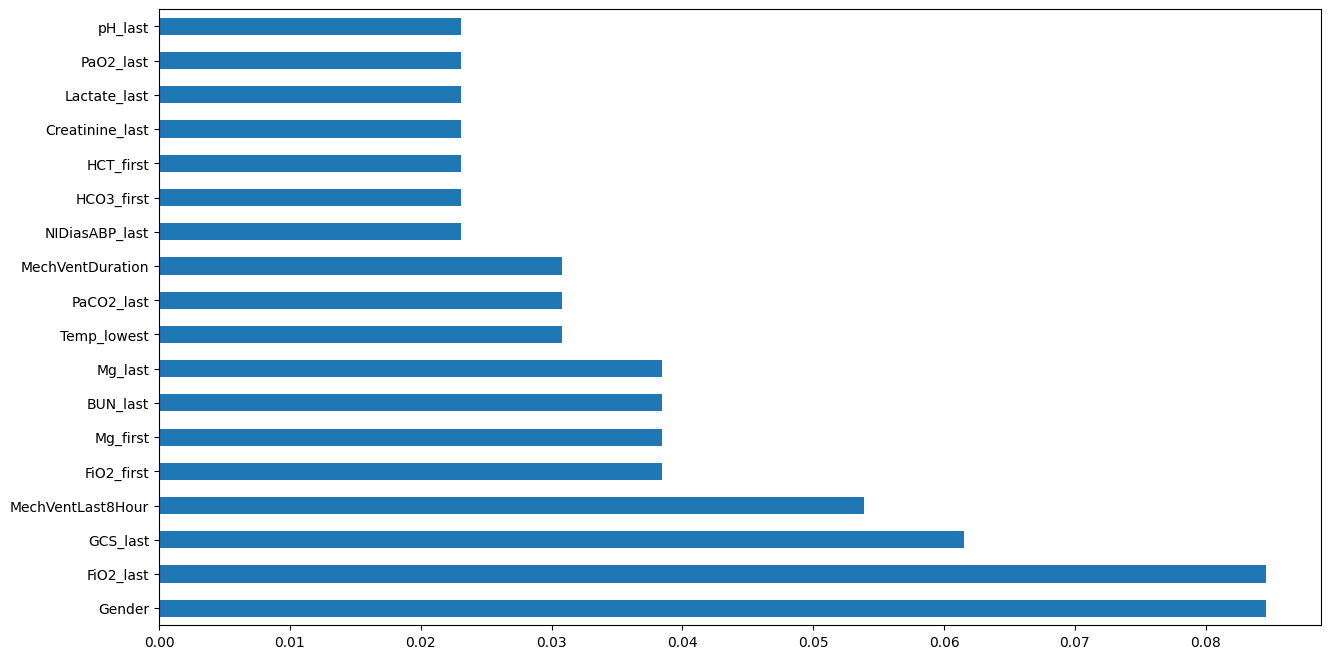

In [41]:
plt.figure(figsize=(15,8))
fi.nlargest(n=18).plot(kind='barh');